In [4]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data
%matplotlib inline

Define dataset using torch

In [37]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

# Import dataset

In [38]:
train_mask = pd.read_csv('../tgs_data/train.csv')
depth = pd.read_csv('../tgs_data/depths.csv')
train_path = "../tgs_data/train/"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [39]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

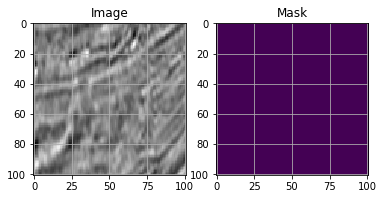

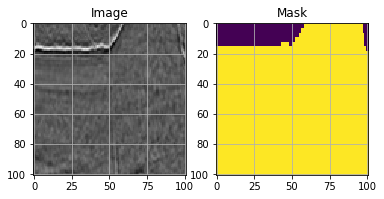

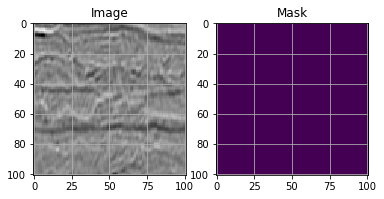

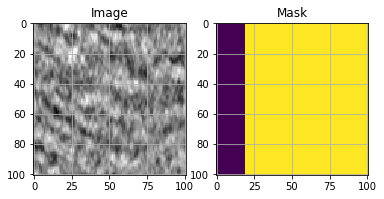

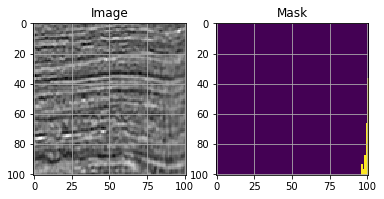

In [42]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

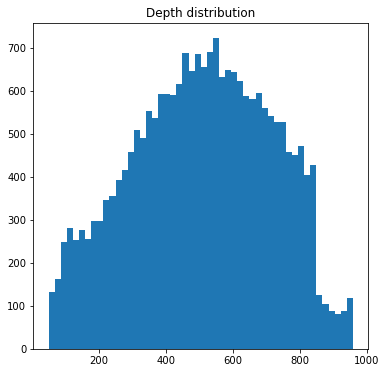

In [43]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

Check correlation between depth and salt amount

In [45]:
def rleToMask(rleString,height,width):
    rows,cols = height,width
    try:
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        
        img = img.reshape(cols,rows)
        img = img.T
    
    except:
        img = np.zeros((cols,rows))
    
    return img

In [46]:
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [48]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [49]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


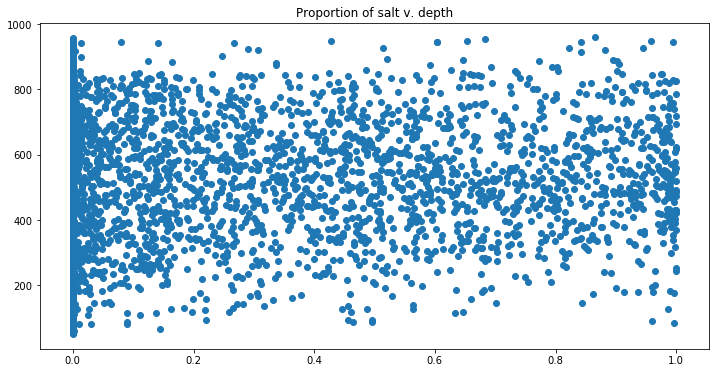

In [58]:
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')

In [61]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.103615803656


In [71]:
image, mask = dataset[:]